# Kernel Trick

In [1]:
import numpy as np
from operator import itemgetter

# Kernel

In [13]:
class RBFKernel:
    def __init__(self, X, sigma):
        self.sigma2 = sigma**2
        self.X = X
        self.values_ = np.empty((X.shape[0], X.shape[0]))
        
    # distance between row i and row j
    def value(self, i, j):
        return np.exp( (-(( self.X[i,:] - self.X[j, :])**2 )).sum() 
                / (2*self.sigma2))
    
    def eval(self, Z, s):
        return np.exp(-((self.X[s, np.newaxis, :] - Z[np.newaxis, :, :])**2).sum(axis=2)
                / (2*self.sigma2))
    

In [12]:
x = np.arange(15).reshape(3,5)
print(x)
print(x[np.newaxis, :, :])
print(x[:, np.newaxis, :])
print(x[:, :, np.newaxis])

[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]]
[[[ 0  1  2  3  4]
  [ 5  6  7  8  9]
  [10 11 12 13 14]]]
[[[ 0  1  2  3  4]]

 [[ 5  6  7  8  9]]

 [[10 11 12 13 14]]]
[[[ 0]
  [ 1]
  [ 2]
  [ 3]
  [ 4]]

 [[ 5]
  [ 6]
  [ 7]
  [ 8]
  [ 9]]

 [[10]
  [11]
  [12]
  [13]
  [14]]]


# SVM

In [33]:
class SVC:
    def __init__(self,C=1.,sigma=1,max_iter=10000):
        self.C = C
        self.sigma = sigma
        self.max_iter = max_iter
    
    def fit(self,X,Y,selections=None):
        a = np.zeros(X.shape[0])
        ay = 0
        kernel = RBFKernel(X, self.sigma)
        indices = np.arange(X.shape[0])
        for _ in range(self.max_iter):
            s = a != 0
            ydf = y*(1 - y*np.dot(a[s]*y[s], kernel.eval(X,s)).T)
            iydf = np.c_[indices, ydf]
            i = int(min(iydf[((a > 0) & (y > 0)) | ((a < self.C) & (y < 0))], 
                       key=itemgetter(1))[0])
            j = int(max(iydf[((a > 0) & (y < 0)) | ((a < self.C) & (y > 0))],
                       key=itemgetter(1))[0])
            if ydf[i] >= ydf[j]:
                break

            ay2 = ay - y[i]*a[i] - y[j]*a[j]
            kii = kernel.value(i,i)
            kij = kernel.value(i,j)
            kjj = kernel.value(j,j)
            s = a != 0
            s[i] = False
            s[j] = False
            kxi = kernel.eval(X[i,:].reshape(1, -1), s).ravel()
            kxj = kernel.eval(X[j,:].reshape(1, -1), s).ravel()
            ai = ((1 - y[i]*y[j] + y[i]*( (kij - kjj)*ay2 - (a[s]*y[s]*(kxi-kxj)).sum()))
                  / (kii + kjj - 2*kij))
            if ai < 0:
                ai = 0
            elif ai > self.C:
                ai = self.C
                aj = (-ai*y[j] - ay2) * y[i]
            ay += y[i] * (ai-a[i]) + y[j] * (aj - a[j])
            if ai == a[i]:
                break
            a[i] = ai
            a[j] = aj
        self.a_ = a
        self.y_ = y
        self.kernel_ = kernel
        s = a != 0.
        self.w0_ = (y[s] - np.dot(a[s]*y[s], kernel.eval(X[s], s))).sum() / s.sum()
        with open("svm.log", "w") as fp:
            print(a, file=fp)
            
    def predict(self, X):
        s = self.a_ != 0.
        return np.sign(self.w0_ + np.dot(self.a_[s] * self.y_[s], self.kernel_.eval(X, s)))

# Test

In [34]:
import matplotlib.pyplot as plt

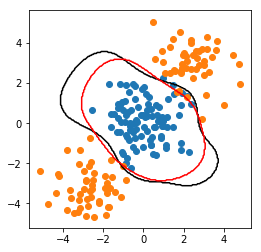

In [52]:
plt.axes().set_aspect("equal")
np.random.seed(0)
X0 = np.random.randn(100,2)
X1_1 = np.random.randn(50,2) + np.array([2.5,3])
X1_2 = np.random.randn(50,2) - np.array([2.5,3])
X1 = np.r_[X1_1, X1_2]
#X1 = np.random.randn(100,2) + np.array([2.5,3])
y = np.array([1] * 100 + [-1] * 100)
X = np.r_[X0, X1]

model = SVC(C=1)
model.fit(X,y)
model2 = SVC(C=.1)
model2.fit(X,y)

xmin, xmax = X[:,0].min(), X[:,0].max()
ymin, ymax = X[:,1].min(), X[:,1].max()

plt.scatter(X0[:,0], X0[:,1])
plt.scatter(X1[:,0], X1[:,1])
xmesh,ymesh = np.meshgrid(np.linspace(xmin,xmax,200),
                          np.linspace(ymin,ymax,200))
Z = model.predict(np.c_[xmesh.ravel(),ymesh.ravel()]).reshape(xmesh.shape)
Z2 = model2.predict(np.c_[xmesh.ravel(),ymesh.ravel()]).reshape(xmesh.shape)
plt.contour(xmesh,ymesh,Z,levels=[0],colors="K")
plt.contour(xmesh,ymesh,Z2,levels=[0],colors="R")